# Fruit Classification

#### Abstract: Exploration of fruit classification using a Convolutional Neural Network (CNN) with hyperparameter tuning. Leveraging a dataset of 33 fruit and vegetable classes, each represented by 100x100 pixel images. Through systematic hyperparameter tuning and comprehensive experimentation, we demonstrate how optimizing key parameters impacts model performance. Our findings shed light on the potential of CNNs for fruit classification and provide insights for future enhancements.

## The Data

Dataset contain Total number of images: 22495.

Training set size: 16854 images (one fruit or vegetable per image).

Test set size: 5641 images (one fruit or vegetable per image).

Number of classes: 33 (fruits and vegetables).

Image size: 100x100 pixels.

Training data filename format: [fruit/vegetable name]_[id].jpg (e.g. Apple Braeburn_100.jpg). Many images are also rotated, to help training.

Testing data filename format: [4 digit id].jpg (e.g. 0001.jpg)

## Importing libraries

In [11]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pickle

## Data Augmentation & Prep.

In [12]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = ImageFolder('/kaggle/input/fruit-recognition/train/train', transform=transform)
train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size
train_data, test_data = random_split(train_data, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

## CNN-Model ResNet18

In [22]:
import torch
import torch.nn as nn
from torchvision import models
# Model
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)  # Load pre-trained ResNet-18
        in_features = self.resnet18.fc.in_features  # Get the number of input features for the last layer
        self.resnet18.fc = nn.Linear(in_features, num_classes)  # Modify the last layer for the desired classes
        
    def forward(self, x):
        return self.resnet18(x)
    pass

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(num_classes=33).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = total_train_loss / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    total_test_loss = 0.0
    correct_test = 0
    total_test = 0

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    test_accuracy = correct_test / total_test
    test_loss = total_test_loss / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - "
          f"Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.4f}")

# Save trained model
model_path = 'resnet18_fruit_classification_model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 251MB/s]


Epoch 1/5 - Train Loss: 0.1242 - Train Acc: 0.9709 - Test Loss: 0.0081 - Test Acc: 0.9991
Epoch 2/5 - Train Loss: 0.0266 - Train Acc: 0.9929 - Test Loss: 0.1853 - Test Acc: 0.9430
Epoch 3/5 - Train Loss: 0.0374 - Train Acc: 0.9901 - Test Loss: 0.0226 - Test Acc: 0.9917
Epoch 4/5 - Train Loss: 0.0126 - Train Acc: 0.9967 - Test Loss: 0.0001 - Test Acc: 1.0000
Epoch 5/5 - Train Loss: 0.0012 - Train Acc: 0.9999 - Test Loss: 0.0001 - Test Acc: 1.0000


## Visualize train and test accuracy

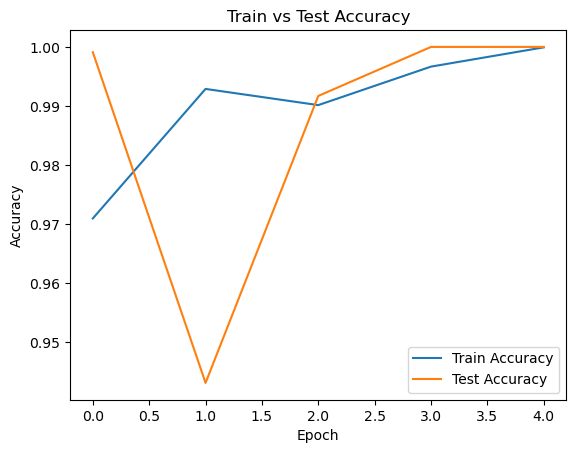

In [25]:
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Test Accuracy')
plt.show()

## Visualize Confusion Matrix

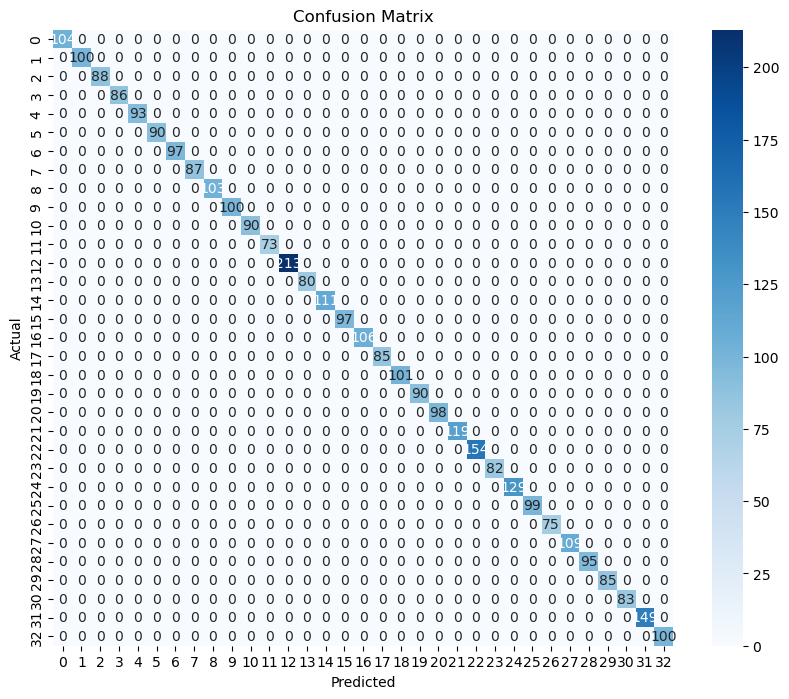

In [29]:
conf_matrix = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()